# Using External SDF Libraries

While `isoext` includes basic SDF primitives for convenience, you can use any SDF library to generate your scalar fields. One excellent option is [`sdf`](https://github.com/fogleman/sdf) by Michael Fogleman—a powerful Python library for constructing complex SDF.

It can be installed by 
```bash
pip install git+https://github.com/fogleman/sdf
```


In [1]:
import sdf
import isoext
import torch
from _viz import show_mesh

Running cmake --build & --install in /home/gcnick/Documents/code/isoext/build/cp312-abi3-linux_x86_64


## Example

This example recreates the [weave](https://github.com/fogleman/sdf/blob/main/examples/weave.py) demo from the `sdf` library.


In [2]:
# The following example is taken from https://github.com/fogleman/sdf/blob/main/examples/weave.py

f = sdf.rounded_box([3.2, 1, 0.25], 0.1).translate((1.5, 0, 0.0625))
f = f.bend_linear(sdf.X * 0.75, sdf.X * 2.25, sdf.Z * -0.1875, sdf.ease.in_out_quad)
f = f.circular_array(3, 0)

f = f.repeat((2.7, 5.4, 0), padding=1)
f |= f.translate((2.7 / 2, 2.7, 0))

f &= sdf.cylinder(10)
f |= (sdf.cylinder(12) - sdf.cylinder(10)) & sdf.slab(z0=-0.5, z1=0.5).k(0.25)

Sample the SDF on a grid. Since the sdf library operates on NumPy arrays, we convert between PyTorch and NumPy:


In [3]:
shape = [256, 256, 256]
aabb_min = [-13, -13, -13]
aabb_max = [13, 13, 13]
grid = isoext.UniformGrid(shape, aabb_min, aabb_max)
points = grid.get_points().cpu().numpy()
points = points.reshape(-1, 3)
values = f(points).reshape(shape)
values = torch.from_numpy(values).cuda()
grid.set_values(values)

Extract the mesh with marching cubes:


Vertices: torch.Size([110818, 3])
Faces: torch.Size([222000, 3])


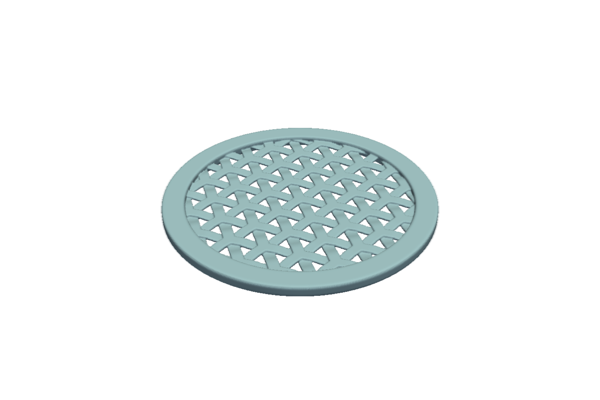

In [4]:
vertices, faces = isoext.marching_cubes(grid)

print(f"Vertices: {vertices.shape}")  # (N, 3) float32
print(f"Faces: {faces.shape}")        # (M, 3) uint32

show_mesh(vertices, faces)
